# WER whole pipeline from scratch including training for a single example

#### Common packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
import pickle, os, warnings, sys
warnings.filterwarnings("ignore")
from graphviz import Digraph
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
os.environ['IN_JUPYTER']='True'
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')

## Amharic

In [4]:
from Cfg import Cfg
C = Cfg('NIST', 8000, 'amharic') 

## Split Corpus into Recordings $\langle A_i,T_i \rangle$

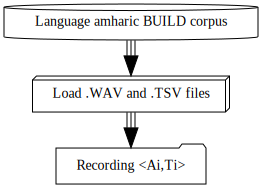

In [5]:
import split_corpus_into_recordings
split_corpus_into_recordings.diagram(C)

In [6]:
from RecordingCorpus import RecordingCorpus
from multiprocessing import Pool
from contextlib import closing
if __name__ == '__main__':
    with closing(Pool(16)) as pool:
        recordings = RecordingCorpus(C, pool)

100%|██████████| 122/122 [00:02<00:00, 44.48it/s]


## Split Recordings $\langle A_i,T_i \rangle$ into Splits $\langle A_{i,j}, T_{i,j} \rangle$ following transcript

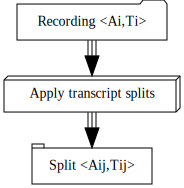

In [7]:
import split_recordings_into_splits
split_recordings_into_splits.diagram(C)

In [8]:
from SplitCorpus import SplitCorpus
splits=SplitCorpus.transcript_split(C, recordings)

In [9]:
id_splits={x.key:x for x in splits.artifacts}

In [13]:
def by_size(corpus):
    return list(reversed(sorted([(x.source.n_seconds,x) for x in corpus.artifacts], key=lambda x: x[0])))

In [14]:
splits_bysize=by_size(splits)

In [17]:
monster_clip = splits_bysize[0][1]

In [18]:
monster_clip.key

('amharic', 'BABEL_OP3_307_82140_20140513_191321_inLine', (546920, 807000))

## Subsplit $A_{i,j}$ on silence and apportion text to trimmed chunks by word sizes in $T_{i,j} = \langle w_{i,j,k} \rangle$ where $w_{i,j,k}=\langle g_{i,j,k,l} \rangle$

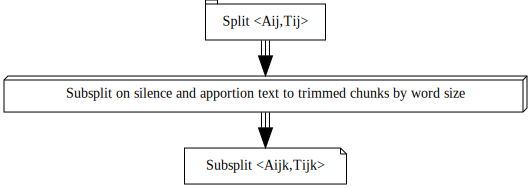

In [10]:
import subsplit_Aij_on_silence_and_apportion_text_by_size
subsplit_Aij_on_silence_and_apportion_text_by_size.diagram

In [11]:
from SubSplitCorpus import SubSplitCorpus
if __name__=="__main__":
    if False:
        with closing(Pool(16)) as pool:
            subsplits=SubSplitCorpus(pool, splits, min_words=2)
        with open('bfgpu.pkl', 'wb') as f:
            pickle.dump(subsplits,f)
    else:
        with open('bfgpu.pkl', 'rb') as f:
            subsplits=pickle.load(f)

In [12]:
id_subsplits={x.key:x for x in subsplits.artifacts}

In [19]:
monster_subsplits=[x for x in subsplits.artifacts if x.key[0:-1]==monster_clip.key]
len(monster_subsplits)

39

# Train ASR NN on subsplits $\langle A_{i,j,k}, T_{i,j,k} \rangle$ inferring $P_{i,j,k}$

In [ ]:
import train_ASR_NN_on_subsplits
train_ASR_NN_on_subsplits.diagram

In [ ]:
import os
os.environ['IN_JUPYTER']='True'

In [22]:
from utils import constant

In [23]:
!mkdir save/ASR_NN

In [24]:
constant.args.save_folder='save/ASR_NN'
constant.args.name='baisemoi'

In [29]:
constant.args.labels_path = C.grapheme_dictionary_fn

In [26]:
from ASR_NN import ASR_NN
model_ASR = ASR_NN(C);

INFO:root:Trainer is initialized


In [35]:
model_ASR.new_model()

In [36]:
# model_ASR.load_model();

In [37]:
subsplit_artifacts=subsplits.artifacts
subsplits.artifacts=monster_subsplits

In [38]:
model_ASR.load_training_set(subsplits, batch_size=1)

In [41]:
ASR_output, ASR_metrics = model_ASR.train()

INFO:root:name amharic_8000_end2end_asr_pytorch_drop0.1_cnn_batch12_4_vgg_layer4_gradscaler


WELCOME TO PAN AMERICAN AIRWAYS


INFO:root:TRAIN


gold |ሰዎች| pred |ን|
gold |ሊያደርጉ| pred ||
gold |ነው| pred ||
gold |ዑእና| pred ||
gold |ሀአልኩህ| pred ||
gold |ጃእ| pred ||
gold |ኻሪሰርች| pred |ነ|
gold |ፑሊያደርጉ| pred ||
gold |ኋእና| pred ||
gold |ፀአነጋገራችንን| pred |ን|
gold |ጱአማርኛችንን| pred ||
gold |ፄእ| pred ||
gold |ሒጥናት| pred ||
gold |ዣእያደረግን| pred ||
gold |ጣነው| pred ||
gold |ዌና| pred ||
gold |ኜጥናት| pred |ንን|
gold |ዲእያደረግን| pred ||
gold |ንስለሆነ| pred ||
gold |ሣነው| pred ||
gold |ፋበቃ| pred |ን|
gold |ታይሄ| pred ||
gold |የነው| pred ||
gold |ጺእንጂ| pred ||
gold |ትሌላ| pred ||
gold |ዪሊያስወራን| pred ||
gold |ዠየሚችል| pred ||
gold |ቢእንትን| pred |ን|
gold |ሌየለም| pred ||
gold |ጊየለም| pred ||
gold |ኸማውራትም| pred ||
gold |ልካለብነ| pred ||
gold |ዬያለብን| pred ||
gold |ፆነገር| pred ||
gold |ፔይሁን| pred ||
gold |ቤየምን| pred |ነን|
gold |ጠከማውራት| pred ||
gold |ጥወደኋላ| pred ||


INFO:root:(Epoch 1) TRAIN LOSS:4.4018 CER:98.27% LR:0.0000091


gold |ባአልልም| pred ||



ValueError: too many values to unpack (expected 2)

In [ ]:
#ASR_output = model_ASR.infer()
ASR_scores = model_ASR.score(ASR_output)

Clean up GPU memory for next phase

In [ ]:
import torch
del model_ASR
torch.cuda.empty_cache() 

## Concatenate $P_{i,j,k}$ giving $P_{i,j} = P_{i,j,1}\|\cdots\|P_{i,j,-1}$

In [ ]:
import concatenate_Pikj_giving_Pij
concatenate_Pikj_giving_Pij.diagram

In [ ]:
for order, hyp in ASR_scores[['order','hyp']].values:
    subsplits.artifacts[order].P = hyp

In [ ]:
Pij={x.key[0:-1]:{} for x in subsplits.artifacts}

for x in subsplits.artifacts:
    Pij[x.key[0:-1]][x.key[-1]] = x.P

for key in Pij:
    Pij[key] = ' '.join([y for x,y in Pij[key].items()])

for key in Pij:
    id_splits[key].P=Pij[key]

## Join text corrector training sets $\langle P_{i,j,k}, T_{i,j,k}\rangle$ and $\langle P_{i,j}, T_{i,j}\rangle$ giving training set $\langle P, T\rangle$

In [ ]:
import join_Pijk_and_Pij_giving_P
join_Pijk_and_Pij_giving_P.diagram

In [ ]:
Pijk_Tijk=[(x.P, x.target.value, x) for x in subsplits.artifacts]
In [ ]:
￼
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram
In [ ]:
￼
​


In [ ]:
Pij_Tij=[(y.P, y.target.value, y) for x,y in id_splits.items() if 'P' in vars(y)]

In [ ]:
P_T=Pijk_Tijk+Pij_Tij

In [ ]:
!ls -l pt.pkl

In [ ]:
if False:
    with open('pt.pkl', 'wb') as f:
        pickle.dump(P_T, f)
else:
    with open('pt.pkl', 'rb') as f:
        P_T = pickle.load(f)

## Infer text-to-text corrector $P\to Q\approx T$ and score

In [ ]:
import train_text_to_text_corrector_on_PQT_score
train_text_to_text_corrector_on_PQT_score.diagram

In [ ]:
from TTC_NN import TTC_NN

In [ ]:
model_TTC = TTC_NN(C);

In [ ]:
model_TTC.load_training_set(P_T, 64)

In [ ]:
model_TTC.load_model('save/afterburner/afterburner_002_96473_1437.pt');

In [ ]:
model_TTC.train(1)

In [ ]:
TTC_output = model_TTC.infer()

In [ ]:
len(model_TTC.train_data), len(TTC_output)

In [ ]:
TTC_scores = model_TTC.score(TTC_output)

In [ ]:
TTC_scores

In [ ]:
del model_TTC
import torch
torch.cuda.empty_cache()

## Subsplit $A_{i,j}$ on silence alone retaining timecode $(s_{i,j,k},e_{i,j,k})$ giving $A_{i,j} = \langle (\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \rangle$ so that $\alpha_{i,j,k} = A_{i,j}[s_{i,j,k}:e_{i,j,k}]$

In [ ]:
import subsplit_Aij_on_silence_retaining_timecode
subsplit_Aij_on_silence_retaining_timecode.diagram

In [ ]:
from SplitCorpus import SplitCorpus
ssplits=SplitCorpus.split_on_silence(C, recordings)

In [ ]:
with open('ssplits.pkl', 'wb') as f:
    pickle.dump(ssplits,f)

## Infer $(\alpha_{i,j,k}, (s_{i,j,k},e_{i,j,k})) \xrightarrow{ASR} p_{i,j,k} $

In [ ]:
import infer_aijk_giving_pijk
infer_aijk_giving_pijk.diagram

In [ ]:
with open('ssplits.pkl', 'rb') as f:
    ssplits=pickle.load(f)

In [ ]:
from ASR_NN import ASR_NN
model_ASR = ASR_NN(C);
model_ASR.load_model();

In [ ]:
model_ASR.load_training_set(ssplits, batch_size=24)
ASR_output = model_ASR.infer()

In [ ]:
bysize=list(reversed(sorted([(x.source.n_seconds,x) for x in ssplits.artifacts], key=lambda x: x[0])))

In [ ]:
bysize[0:3]

In [ ]:
%matplotlib inline
bysize[10][1].display()

In [ ]:
artifacts=ssplits.artifacts

In [ ]:
ssplits.artifacts=[bysize[10][1]]

In [ ]:
model_ASR.load_training_set(ssplits, batch_size=24)
ASR_output = model_ASR.train()

In [ ]:
ASR_output

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $p_{i,j,k} \to p_{i,j}$

In [ ]:
import concatenate_pikj_giving_pij
concatenate_pikj_giving_pij.diagram

## Infer $p_{i,j} \xrightarrow{TT} (q_{i,j},(s_{i,j,0},e_{i,j,-1}))$ 

In [ ]:
import infer_pij_giving_qij
infer_pij_giving_qij.diagram

In [ ]:
torch.cuda.empty_cache() 

## Concatenate $\langle \langle (q_{i,j,k},(s_{i,j,k},e_{i,j,k})) \rangle \rangle $ giving transcript $Q_i = \langle (q_{i,j}, (s_{i,j,0},e_{i,j,-1})) \rangle$

In [ ]:
import concatenate_qijk_giving_Qi
concatenate_qijk_giving_Qi.diagram

## Save transcript $Q_i$ in .CTM format

In [ ]:
import save_transcript_Qi_in_CTM_format
save_transcript_Qi_in_CTM_format.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` for each recording individually

In [ ]:
import score_TiQi_using_sclite_per_recording
score_TiQi_using_sclite_per_recording.diagram

## Score $\langle T_i,Q_i\rangle$ using `sclite` collectively

In [ ]:
import score_TiQi_using_sclite_on_all_recordings_together
score_TiQi_using_sclite_on_all_recordings_together.diagram